использовал советы с кагла и этого доклада https://isi-web.org/sites/default/files/2024-02/Handling-Data-Imbalance-in-Machine-Learning.pdf

в этой задаче нам важнее F1 мера

идеи закончились

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from plots import *
from helper import *
import random

In [68]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [69]:
df = pd.read_csv('creditcard.csv')

df.drop(columns=['Time']) # Признак Time содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных.

X, y = divide_data(df, 'Class')


In [70]:
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    # ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=SEED, verbose=False))
]

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## Baseline 

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

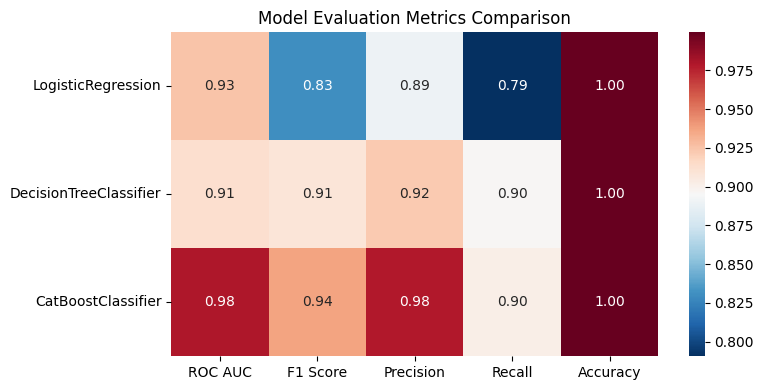

In [72]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)

In [73]:
initial_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.925175,0.830430,0.889936,0.790516,0.998985
DecisionTreeClassifier,0.912444,0.908745,0.922317,0.896214,0.999389
CatBoostClassifier,0.979427,0.937035,0.978513,0.902401,0.999600


## Undersampling

попробуем удалить часть отрицательного класса сделав соотношение 1/10

In [74]:
positive_df = df[df['Class'] == 1]
negative_df = df[df['Class'] == 0]

negative_sample = negative_df.sample(n=5000, random_state=42)

balanced_df = pd.concat([positive_df, negative_sample], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_balanced, y_balanced = divide_data(balanced_df, 'Class')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

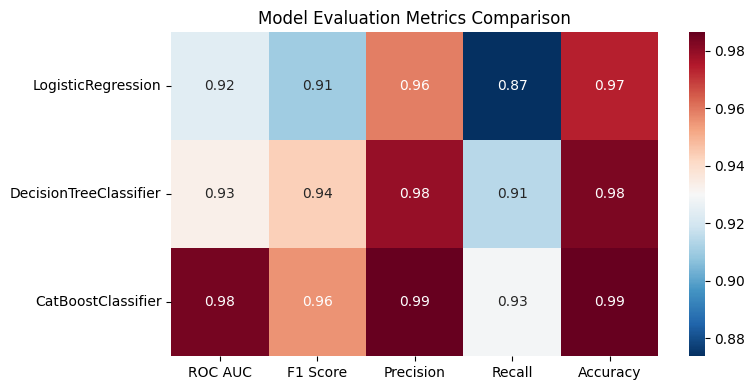

In [75]:
balanced_metrics = train_evaluate_models_cv(
    models=models,
    X=X_balanced,
    y=y_balanced,
    cv=cv,
    seed=SEED
)

In [76]:
balanced_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.923788,0.910111,0.959038,0.873818,0.973599
DecisionTreeClassifier,0.933321,0.943665,0.978946,0.914505,0.982884
CatBoostClassifier,0.983959,0.955203,0.986276,0.929198,0.986342


(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.001387  0.079682   0.069101  0.083303 -0.025386
 DecisionTreeClassifier  0.020876  0.034920   0.056629  0.018291 -0.016505
 CatBoostClassifier      0.004532  0.018168   0.007763  0.026797 -0.013257)

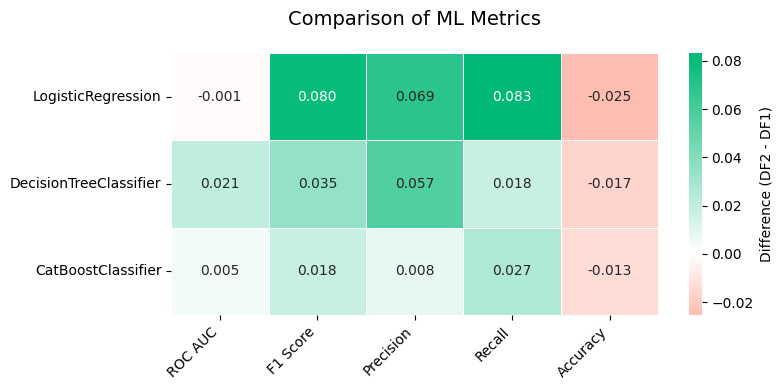

In [77]:
compare_metrics_heatmap(initial_metrics, balanced_metrics)

recall подрос - хорошо

попробуем взять больше негативных. соотношение 1/100

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

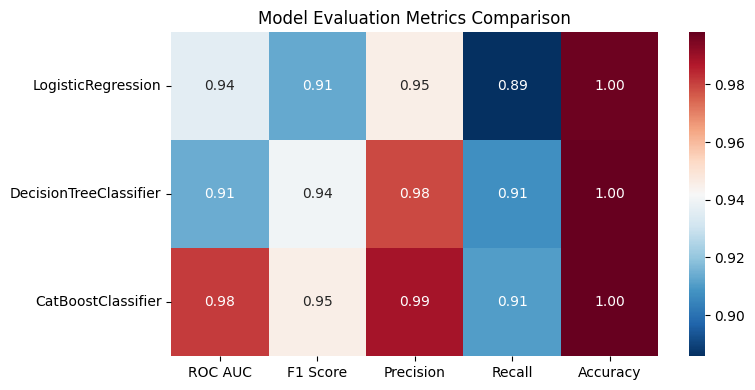

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.936006,0.912914,0.945813,0.885687,0.996851
DecisionTreeClassifier,0.913829,0.939926,0.978940,0.907344,0.997861
CatBoostClassifier,0.981060,0.945691,0.988549,0.910444,0.998079


In [78]:
positive_df = df[df['Class'] == 1]
negative_df = df[df['Class'] == 0]

negative_sample = negative_df.sample(n=50000, random_state=42)

balanced_df2 = pd.concat([positive_df, negative_sample], ignore_index=True)

balanced_df2 = balanced_df2.sample(frac=1, random_state=42).reset_index(drop=True)

X_balanced, y_balanced = divide_data(balanced_df2, 'Class')

balanced_metrics2 = train_evaluate_models_cv(
    models=models,
    X=X_balanced,
    y=y_balanced,
    cv=cv,
    seed=SEED
)

balanced_metrics2

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.012217  0.002803  -0.013225  0.011869  0.023252
 DecisionTreeClassifier -0.019492 -0.003739  -0.000006 -0.007161  0.014977
 CatBoostClassifier     -0.002899 -0.009511   0.002273 -0.018754  0.011737)

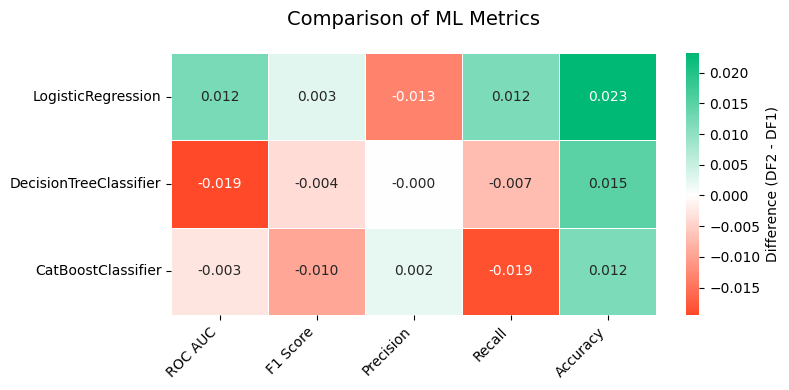

In [79]:
compare_metrics_heatmap(balanced_metrics, balanced_metrics2)

стало хуже

## Class balancing

попробуем подобрать коэффициенты

In [80]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

class_weights

{np.int64(0): np.float64(0.5008652375006595),
 np.int64(1): np.float64(289.4380081300813)}

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

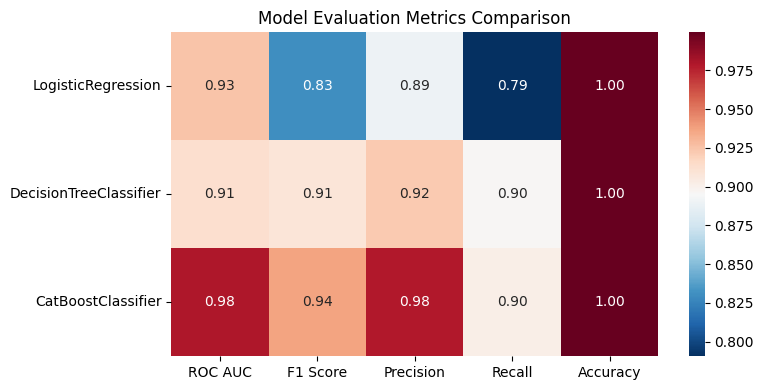

In [81]:
models2 = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    # ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=SEED, verbose=False, class_weights=class_weights))
]

weight_balanced_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    cv=cv,
    seed=SEED
)

In [82]:
weight_balanced_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.925175,0.830430,0.889936,0.790516,0.998985
DecisionTreeClassifier,0.912444,0.908745,0.922317,0.896214,0.999389
CatBoostClassifier,0.979427,0.937035,0.978513,0.902401,0.999600


(<Figure size 800x400 with 2 Axes>,
                         ROC AUC  F1 Score  Precision  Recall  Accuracy
 LogisticRegression          0.0       0.0        0.0     0.0       0.0
 DecisionTreeClassifier      0.0       0.0        0.0     0.0       0.0
 CatBoostClassifier          0.0       0.0        0.0     0.0       0.0)

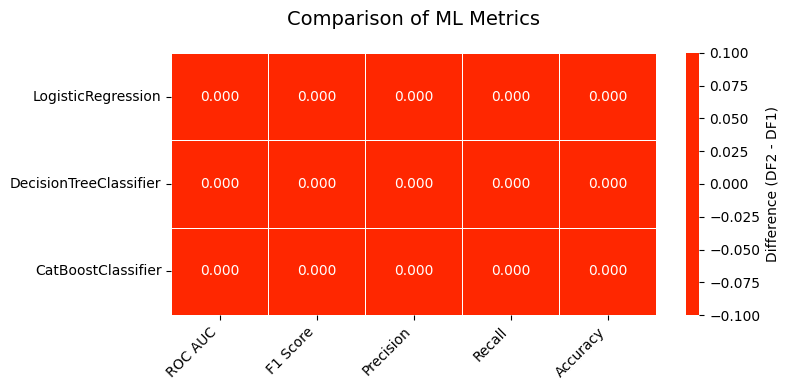

In [83]:
compare_metrics_heatmap(initial_metrics, weight_balanced_metrics)

нет изменений

## Gaussian Mixture Sampling

вычитал что он вроде неплохо работает с данными после PCA, лучше чем SMOTE

In [120]:
from sklearn.mixture import GaussianMixture

In [121]:
X_minority = df[df['Class'] == 1]

X_minority.drop(columns=['Amount', 'Class', 'Time'], inplace=True)

lowest_bic = np.inf
best_gmm = None
best_k = None

for k in range(1, 15):
    gmm = GaussianMixture(n_components=k, random_state=SEED)
    gmm.fit(X_minority)
    bic = gmm.bic(X_minority)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

best_k

C:\Users\nemow\AppData\Local\Temp\ipykernel_39752\3316306856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_minority.drop(columns=['Amount', 'Class', 'Time'], inplace=True)


7

In [122]:
cols_gmm = [c for c in df.columns if c not in ["Amount", "Time"]]

X_minority = df[y == 1][cols_gmm]
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm.fit(X_minority)

X_new_gmm, _ = gmm.sample(500)
df_new = pd.DataFrame(X_new_gmm, columns=cols_gmm)

for c in ["Amount", "Time"]:
    df_new[c] = X[c].median()

df_new["Class"] = 1

df_augmented = pd.concat([df, df_new], ignore_index=True)

df_augmented

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285302,84692.0,-13.191403,12.786968,-9.907115,3.320449,-4.803243,5.759615,-18.749163,-37.354307,-0.391405,...,27.204325,-8.886510,5.302294,-0.638512,0.261527,-0.108196,1.270658,0.941153,22.00,1
285303,84692.0,-13.192168,12.784286,-9.906921,3.321059,-4.800195,5.759738,-18.750590,-37.353017,-0.391992,...,27.204197,-8.888188,5.305538,-0.641420,0.265034,-0.108034,1.269522,0.939628,22.00,1
285304,84692.0,-13.191892,12.786276,-9.906932,3.319307,-4.800818,5.760184,-18.750610,-37.352399,-0.390720,...,27.202997,-8.887667,5.304238,-0.638642,0.261939,-0.109176,1.268923,0.939249,22.00,1
285305,84692.0,-13.193136,12.786245,-9.906994,3.319596,-4.802166,5.758481,-18.753169,-37.354590,-0.391781,...,27.202041,-8.885716,5.304676,-0.640808,0.263908,-0.109200,1.270210,0.940237,22.00,1


In [123]:
df_augmented['Class'].value_counts() # посмотрим на таргет

Class
0    284315
1       992
Name: count, dtype: int64

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

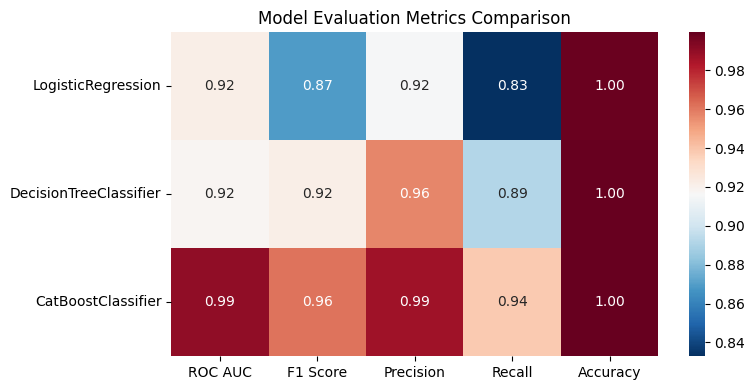

In [124]:
X_gms, y_gms = divide_data(df_augmented, 'Class')

gms_metrics = train_evaluate_models_cv(
    models=models,
    X=X_gms,
    y=y_gms,
    cv=cv,
    seed=SEED
)

In [125]:
gms_metrics

,ROC AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.921745,0.869130,0.915061,0.832884,0.998374
DecisionTreeClassifier,0.917688,0.921623,0.956869,0.892005,0.998991
CatBoostClassifier,0.990350,0.961096,0.987094,0.937963,0.999488


(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.003430  0.038700   0.025125  0.042368 -0.000612
 DecisionTreeClassifier  0.005244  0.012878   0.034552 -0.004210 -0.000398
 CatBoostClassifier      0.010923  0.024061   0.008582  0.035562 -0.000111)

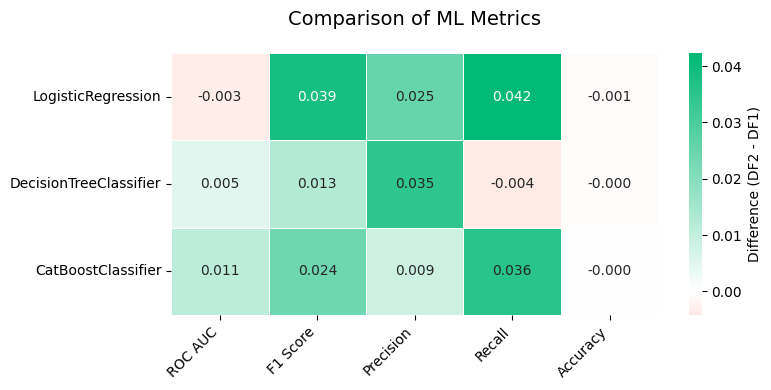

In [126]:
compare_metrics_heatmap(initial_metrics, gms_metrics)

Я удвоил выборку, но не уверен что этим данным можно доверять

## Isolated forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

iso = IsolationForest(random_state=42, contamination=0.00173)
iso.fit(X)

# предсказываем: 1 — нормальный, -1 — аномалия
y_pred = iso.predict(X)

y_pred_bin = [0 if x==1 else 1 for x in y_pred]

roc = roc_auc_score(y, y_pred_bin)
f1 = f1_score(y, y_pred_bin)
precision = precision_score(y, y_pred_bin)
recall = recall_score(y, y_pred_bin)

roc, f1, precision, recall

(0.6274033695879226,
 0.25583756345177666,
 0.25557809330628806,
 0.25609756097560976)

показатели не воодушевляют